# Lec 32: GANs II

## Instructions

1. The GAN model covered in the lecture used fully connected layers in discriminator and generator. In this exercise, use at least two convolutional layers in discriminator and two transposed convolutions in the generator. Train the model on MNIST data and tweak the hyperparameters as needed to do training effectively.
2. Compare the results of your new GAN generator with the one in the lecture.

## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Pytorch imports
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [3]:
# Import helper files
from helpers.helper_utils import set_all_seeds
from helpers.helper_data import get_dataloaders_mnist
from helpers.helper_train import train_gan
from helpers.helper_plots import plot_generated_images
from helpers.helper_models import Reshape

## Settings

In [4]:
# Hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 128
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002
LATENT_DIM = 100

# Other settings
DEVICE = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
IMAGE_CHANNELS = 1
SAVED_DATA_PATH = '/Users/nxvgalang/Documents/main/college/cs6073/uc-cs6073-deep-learning/lec32/saved_data/'

set_all_seeds(RANDOM_SEED)
print(f'Device: {DEVICE}')

Device: cpu


In [5]:
# If running on Colab, uncomment this code

# from google.colab import drive
# drive.mount('/content/drive')

# SAVED_DATA_PATH = 'drive/MyDrive/saved_data/'

## MNIST Dataset

### Custom Transformations

In [6]:
custom_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

### Get Data Loaders

In [7]:
train_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms
)

# Verify dataset
for images, labels in train_loader:
    print(f'Image batch dimensions: {images.size()}')
    print(f'Image label dimensions: {labels.size()}')
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


### View Training Images

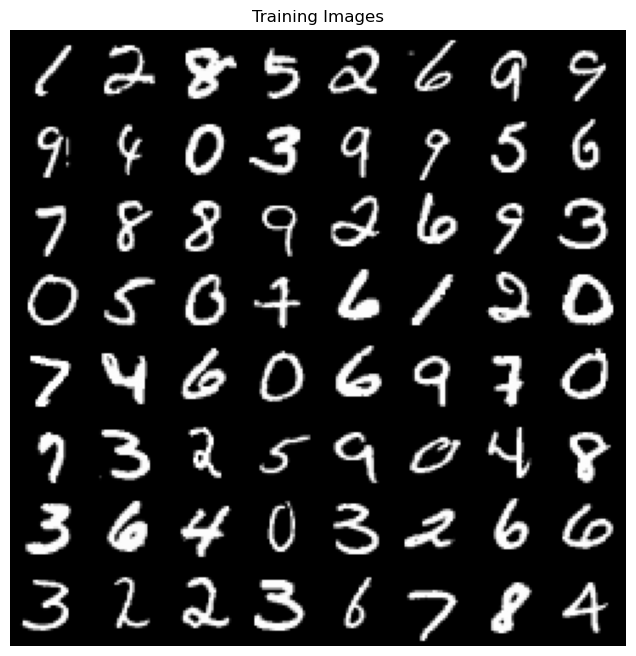

In [8]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            images[:64],
            padding=2,
            normalize=True
        ),
        (1, 2, 0)
    )
)
plt.show()

## GAN Model (from lecture)

In [9]:
class GAN(nn.Module):

    def __init__(
        self,
        latent_dim=100,
        image_height=28,
        image_width=28,
        color_channels=1
    ):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels

        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(128, image_height * image_width * color_channels),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Flatten(),

            nn.Linear(image_height * image_width * color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(128, 1)
        )
    
    def generator_forward(self, z):
        z = torch.flatten(z, start_dim=1)
        img = self.generator(z)
        img = img.view(
            z.size(0),
            self.color_channels,
            self.image_height,
            self.image_width
        )
        return img

    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [10]:
model1 = GAN()
model1.to(DEVICE)

generator_optimizer_1 = torch.optim.Adam(
    model1.generator.parameters(),
    betas=(0.5, 0.999),
    lr=GENERATOR_LEARNING_RATE
)

discriminator_optimizer_1 = torch.optim.Adam(
    model1.discriminator.parameters(),
    betas=(0.5, 0.999),
    lr=DISCRIMINATOR_LEARNING_RATE
)

## Training

In [11]:
log_dict_1 = train_gan(
    model1,
    generator_optimizer_1,
    discriminator_optimizer_1,
    num_epochs=NUM_EPOCHS,
    latent_dim=LATENT_DIM,
    train_loader=train_loader,
    device=DEVICE
)

Epoch: 001/1 | Batch: 000/469 | Gen/Dis Loss: 0.7133/0.7116
Epoch: 001/1 | Batch: 100/469 | Gen/Dis Loss: 0.5927/0.4903
Epoch: 001/1 | Batch: 200/469 | Gen/Dis Loss: 0.6184/0.5536
Epoch: 001/1 | Batch: 300/469 | Gen/Dis Loss: 0.7336/0.5349
Epoch: 001/1 | Batch: 400/469 | Gen/Dis Loss: 0.9260/0.4383
Time elapsed: 0.22 min
Total Training Time: 0.22 min


In [12]:
torch.save(model1.state_dict(), SAVED_DATA_PATH + 'model1.pt')

# Can't save Tensor in JSON file, so convert to list before saving
for i in range(len(log_dict_1['images_from_noise_per_epoch'])):
    log_dict_1['images_from_noise_per_epoch'][i] = log_dict_1['images_from_noise_per_epoch'][i].tolist()

with open(SAVED_DATA_PATH + 'logs1.json', 'w') as f:
    json.dump(log_dict_1, f)

## Load Saved Data

In [13]:
SAVED_DATA_PATH = '/Users/nxvgalang/Documents/main/college/cs6073/uc-cs6073-deep-learning/lec32/saved_data/'

model1 = GAN()
model1.load_state_dict(torch.load(SAVED_DATA_PATH + 'model1.pt', map_location=DEVICE))

with open(SAVED_DATA_PATH + 'logs1.json', 'r') as f:
    log_dict_1 = json.loads(f.read())

# Convert image data back to Tensors
for i in range(len(log_dict_1['images_from_noise_per_epoch'])):
    log_dict_1['images_from_noise_per_epoch'][i] = torch.Tensor(log_dict_1['images_from_noise_per_epoch'][i])

## Plotting

### Plot Generated Images

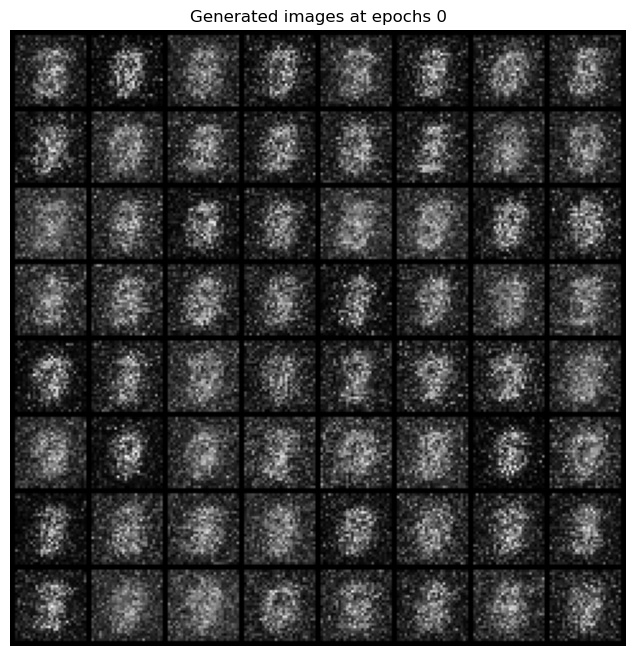

IndexError: list index out of range

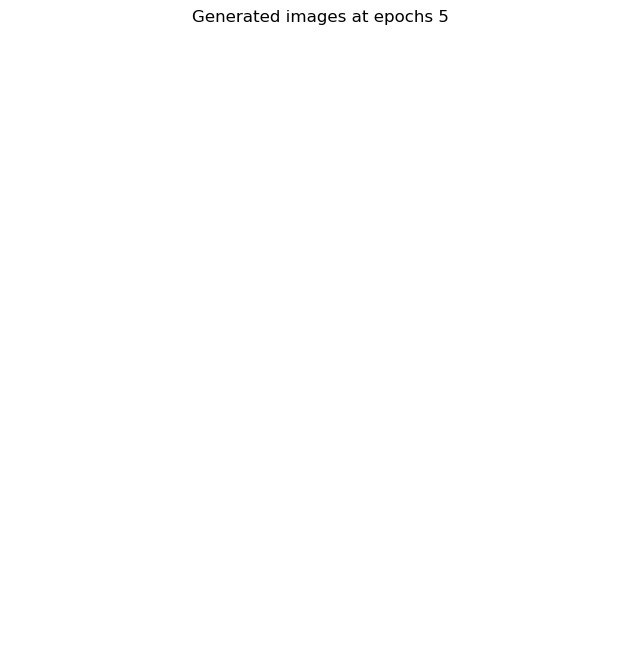

In [14]:
plot_generated_images(log_dict=log_dict_1, num_epochs=NUM_EPOCHS)

## Model (Deep Convolutional GAN)

In [ ]:
class DCGAN(nn.Module):

    def __init__(
        self,
        latent_dim=100,
        image_height=28,
        image_width=28,
        color_channels=1
    ):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels

        self.generator = nn.Sequential(
            # Input: 100 features

            # Output: 784 features
            nn.Linear(latent_dim, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(inplace=True),

            # Output: 16 channels x 7x7 images
            Reshape(-1, 16, 7, 7),

            # Output: 32 channels x 14x14 images
            nn.ConvTranspose2d(
                16, 32,
                kernel_size=5, stride=2, padding=2,
                output_padding=1, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),

            # Output: 1 channel x 28x28 images
            nn.ConvTranspose2d(
                32, 1,
                kernel_size=5, stride=2, padding=2,
                output_padding=1, bias=False
            ),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            # Input: 1 channel x 28x28 images

            # Output: 32 channels x 14x14 images
            nn.Conv2d(
                1, 32,
                kernel_size=5, stride=2, padding=2,
                bias=False
            ),
            nn.LeakyReLU(inplace=True),

            # Output: 16 channels x 7x7 images
            nn.Conv2d(
                32, 16,
                kernel_size=5, stride=2, padding=2,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),

            # Output: 784 features
            nn.Flatten(),

            # Output: 784 features
            nn.Linear(784, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(inplace=True),

            # Output: 1 feature
            nn.Linear(784, 1)
        )
    
    def generator_forward(self, z):
        z = torch.flatten(z, start_dim=1)
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [ ]:
model2 = DCGAN()
model2.to(DEVICE)

generator_optimizer_2 = torch.optim.Adam(
    model2.generator.parameters(),
    betas=(0.5, 0.999),
    lr=GENERATOR_LEARNING_RATE
)

discriminator_optimizer_2 = torch.optim.Adam(
    model2.discriminator.parameters(),
    betas=(0.5, 0.999),
    lr=DISCRIMINATOR_LEARNING_RATE
)

## Training

In [ ]:
log_dict_2 = train_gan(
    model2,
    generator_optimizer_2,
    discriminator_optimizer_2,
    num_epochs=20,
    latent_dim=LATENT_DIM,
    train_loader=train_loader,
    device=DEVICE
)

In [ ]:
torch.save(model2.state_dict(), SAVED_DATA_PATH + 'model2.pt')

# Can't save Tensor in JSON file, so convert to list before saving
for i in range(len(log_dict_2['images_from_noise_per_epoch'])):
    log_dict_2['images_from_noise_per_epoch'][i] = log_dict_2['images_from_noise_per_epoch'][i].tolist()

with open(SAVED_DATA_PATH + 'logs2.json', 'w') as f:
    json.dump(log_dict_2, f)

## Load Saved Data

In [ ]:
SAVED_DATA_PATH = '/Users/nxvgalang/Documents/main/college/cs6073/uc-cs6073-deep-learning/lec32/saved_data/'

model2 = DCGAN()
model2.load_state_dict(torch.load(SAVED_DATA_PATH + 'model2.pt', map_location=DEVICE))

with open(SAVED_DATA_PATH + 'logs2.json', 'r') as f:
    log_dict_2 = json.loads(f.read())

# Convert image data back to Tensors
for i in range(len(log_dict_2['images_from_noise_per_epoch'])):
    log_dict_2['images_from_noise_per_epoch'][i] = torch.Tensor(log_dict_2['images_from_noise_per_epoch'][i])

## Plotting

### Plot Generated Images

In [ ]:
plot_generated_images(log_dict=log_dict_2, num_epochs=20)